In [182]:
import tensorflow as tf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import r2_score


from scipy import stats
import plotly.graph_objects as go
import plotly.express as px  # For easier rendering
import plotly.io as pio
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential  # Import Sequential
from tensorflow.keras import Model  # Import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.optimizers import Adam

In [183]:
start="2012-01-01"
end="2022-12-21"
stock="GOOG"
data=yf.download(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [184]:
data.columns = ['_'.join(col).strip() for col in data.columns.values]

print(data.head())  # Verify the new column names

            Adj Close_GOOG  Close_GOOG  High_GOOG   Low_GOOG  Open_GOOG  \
Date                                                                      
2012-01-03       16.532528   16.573130  16.641375  16.248346  16.262545   
2012-01-04       16.603836   16.644611  16.693678  16.453827  16.563665   
2012-01-05       16.373516   16.413727  16.537264  16.344486  16.491436   
2012-01-06       16.150156   16.189817  16.438385  16.184088  16.417213   
2012-01-09       15.465409   15.503389  16.114599  15.472754  16.102144   

            Volume_GOOG  
Date                     
2012-01-03    147611217  
2012-01-04    114989399  
2012-01-05    131808205  
2012-01-06    108119746  
2012-01-09    233776981  


In [185]:
data.duplicated().values.any()

False

In [186]:
data.reset_index(inplace=True)

In [187]:
data.drop(columns=['Adj Close_GOOG'], axis=1,inplace=True)
data

,Date,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,Volume_GOOG
0,2012-01-03,16.573130,16.641375,16.248346,16.262545,147611217
1,2012-01-04,16.644611,16.693678,16.453827,16.563665,114989399
2,2012-01-05,16.413727,16.537264,16.344486,16.491436,131808205
3,2012-01-06,16.189817,16.438385,16.184088,16.417213,108119746
4,2012-01-09,15.503389,16.114599,15.472754,16.102144,233776981
...,...,...,...,...,...,...
2756,2022-12-14,95.309998,97.220001,93.940002,95.540001,26452900
2757,2022-12-15,91.199997,94.029999,90.430000,93.540001,28298800
2758,2022-12-16,90.860001,91.750000,90.010002,91.199997,48485500
2759,2022-12-19,89.150002,91.199997,88.925003,90.879997,23020500


In [188]:
scaler = StandardScaler()

# Select columns to scale
columns_to_scale = ['Close_GOOG', 'High_GOOG', 'Low_GOOG', 'Open_GOOG', 'Volume_GOOG']

# Apply the scaler
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

print(data)

           Date  Close_GOOG  High_GOOG  Low_GOOG  Open_GOOG  Volume_GOOG
0    2012-01-03   -1.083270  -1.083934 -1.089017  -1.091578     2.832009
1    2012-01-04   -1.081272  -1.082489 -1.083206  -1.083160     1.926893
2    2012-01-05   -1.087726  -1.086811 -1.086298  -1.085179     2.393543
3    2012-01-06   -1.093986  -1.089543 -1.090834  -1.087254     1.736290
4    2012-01-09   -1.113177  -1.098490 -1.110951  -1.096063     5.222740
...         ...         ...        ...       ...        ...          ...
2756 2022-12-14    1.118014   1.142664  1.108118   1.124758    -0.529615
2757 2022-12-15    1.003109   1.054516  1.008854   1.068845    -0.478399
2758 2022-12-16    0.993603   0.991514  0.996977   1.003426     0.081695
2759 2022-12-19    0.945796   0.976316  0.966293   0.994480    -0.624849
2760 2022-12-20    0.959215   0.937078  0.941265   0.934373    -0.653808

[2761 rows x 6 columns]


In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2761 non-null   datetime64[ns]
 1   Close_GOOG   2761 non-null   float64       
 2   High_GOOG    2761 non-null   float64       
 3   Low_GOOG     2761 non-null   float64       
 4   Open_GOOG    2761 non-null   float64       
 5   Volume_GOOG  2761 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 129.5 KB


In [190]:
data.describe()

,Date,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,Volume_GOOG
count,2761,2761.000000,2.761000e+03,2761.000000,2761.000000,2.761000e+03
mean,2017-06-28 05:55:10.539659520,0.000000,8.235193e-17,0.000000,0.000000,4.117596e-17
min,2012-01-03 00:00:00,-1.157331,-1.155256e+00,-1.156530,-1.156056,-1.259174e+00
25%,2014-10-01 00:00:00,-0.779797,-7.794725e-01,-0.781338,-0.779521,-5.688724e-01
50%,2017-06-28 00:00:00,-0.248268,-2.541091e-01,-0.243350,-0.247553,-3.494038e-01
75%,2020-03-26 00:00:00,0.394153,3.887915e-01,0.367841,0.387163,2.179237e-01
max,2022-12-20 00:00:00,2.666830,2.659143e+00,2.690324,2.699378,1.259712e+01
std,NaN,1.000181,1.000181e+00,1.000181,1.000181,1.000181e+00


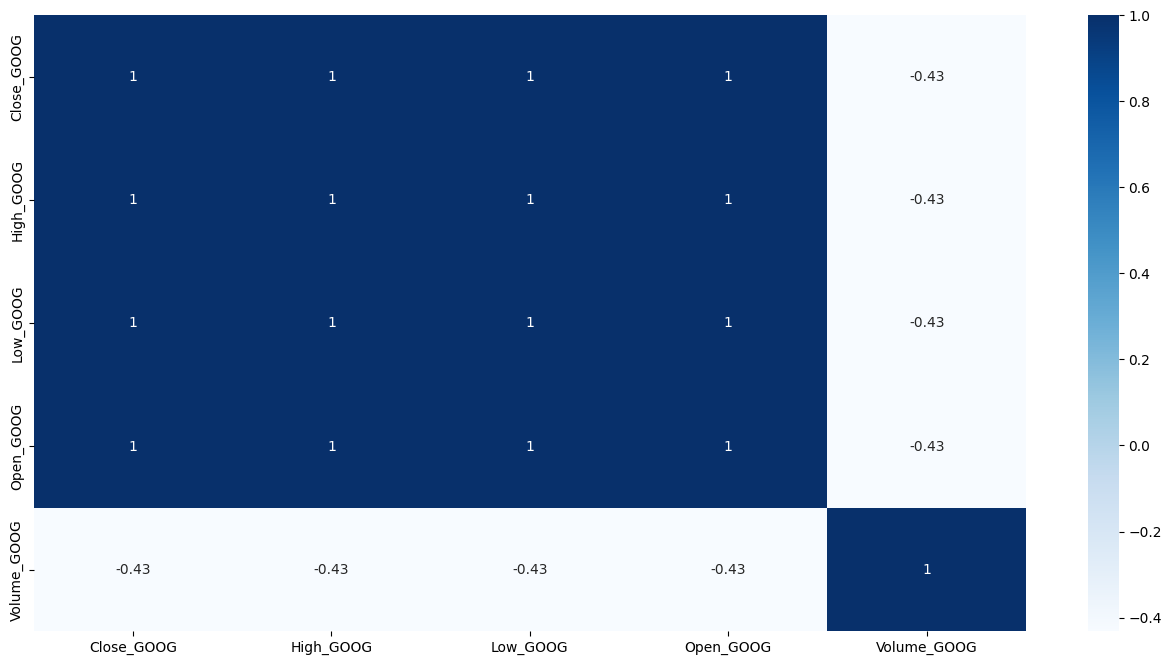

In [191]:
numeric_df = data.select_dtypes(include=['number'])
correlations = numeric_df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(numeric_df.corr(), cmap="Blues", annot=True)
plt.show()

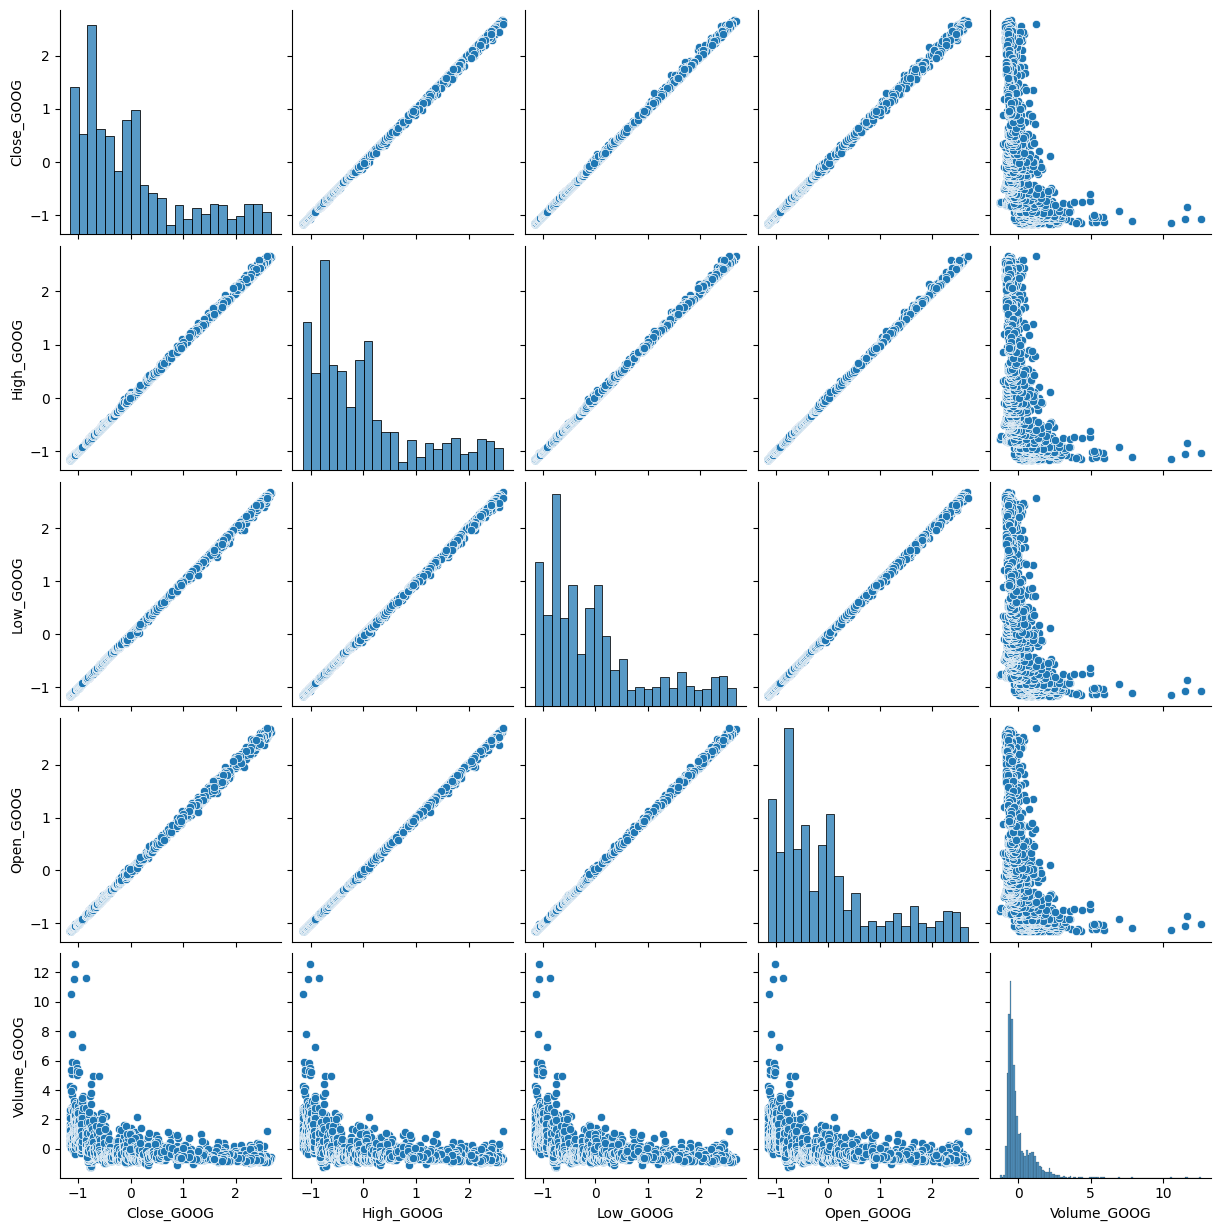

In [192]:
sns.pairplot(data)

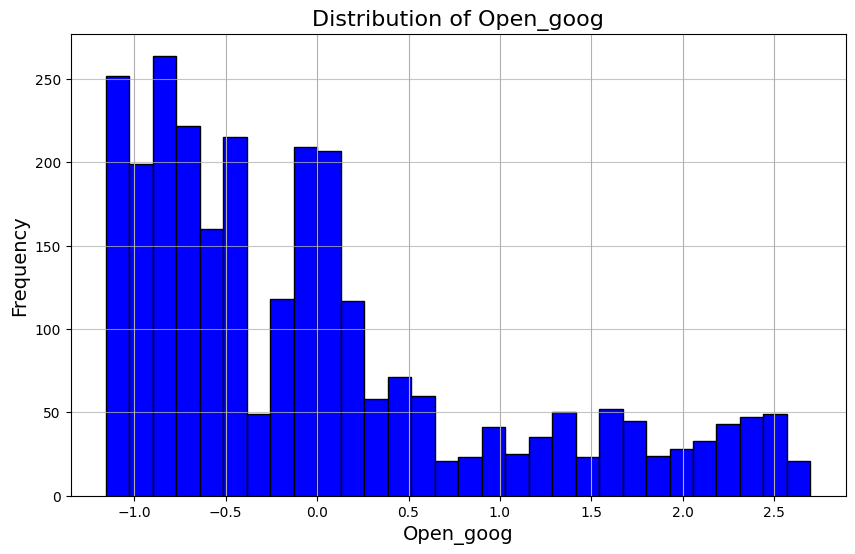

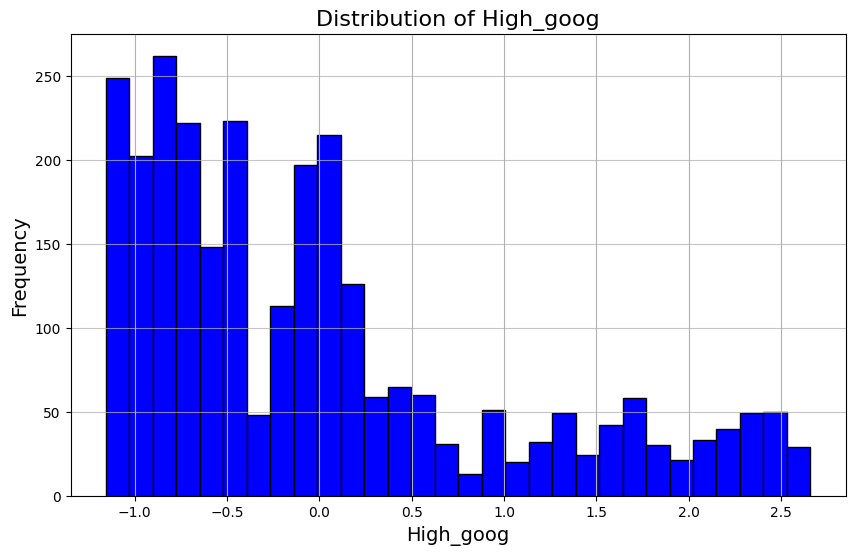

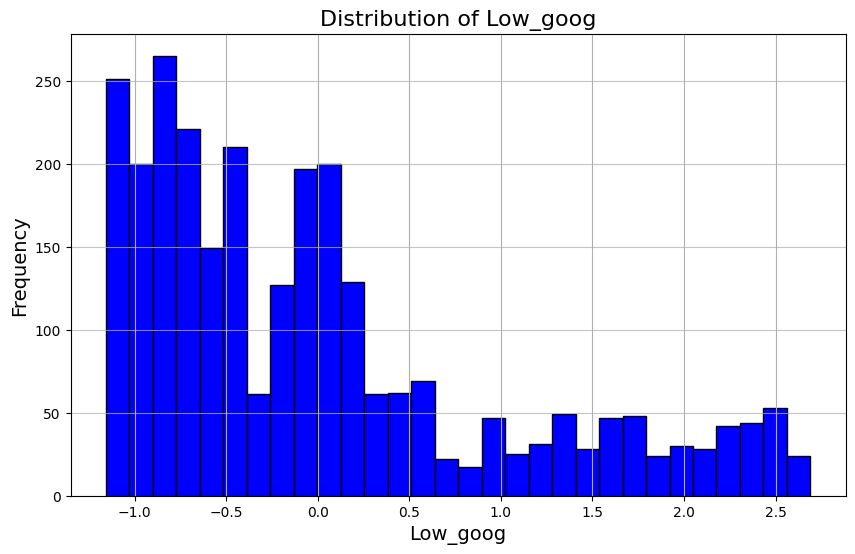

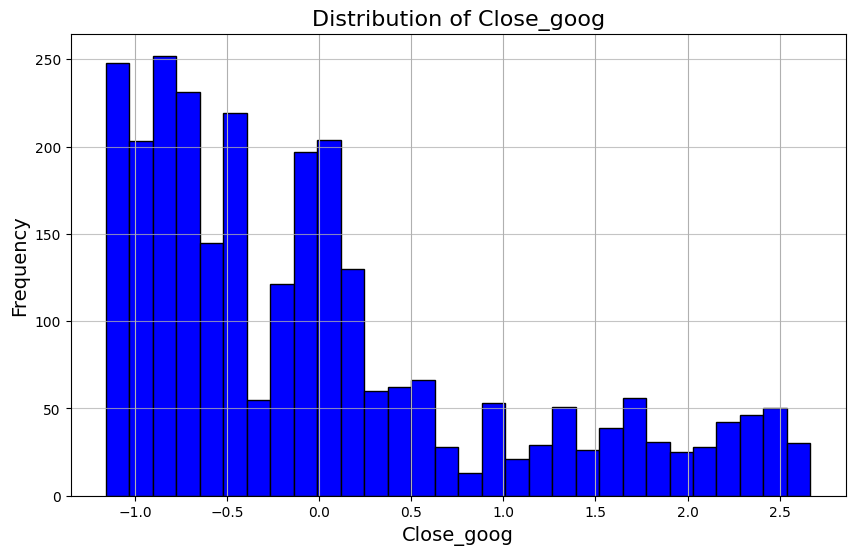

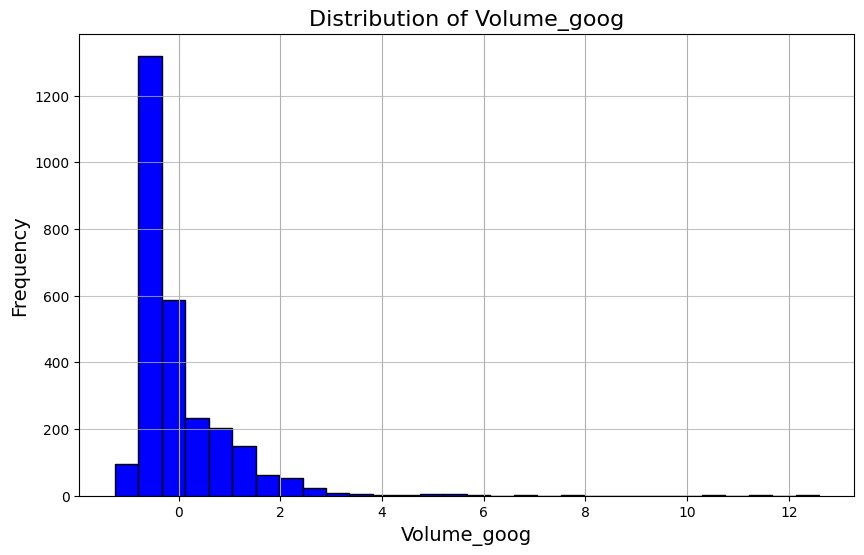

In [193]:
columns_to_plot = ['Open_GOOG', 'High_GOOG', 'Low_GOOG', 'Close_GOOG', 'Volume_GOOG']
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    data[column].hist(bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

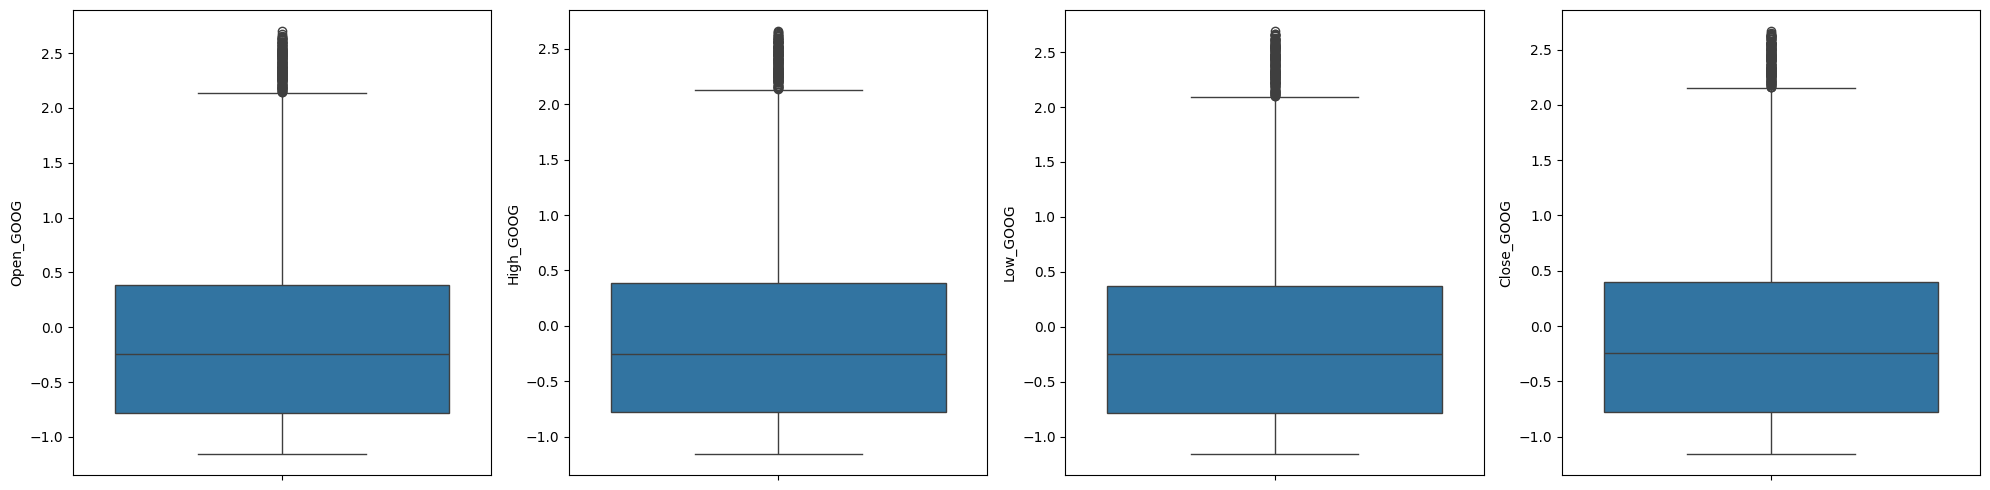

In [194]:
f, axes = plt.subplots(1, 4, figsize=(20,5))
sns.boxplot(y='Open_GOOG', data=data, ax=axes[0])
sns.boxplot(y='High_GOOG', data=data, ax=axes[1])
sns.boxplot(y='Low_GOOG', data=data, ax=axes[2])
sns.boxplot(y='Close_GOOG', data=data, ax=axes[3])
plt.tight_layout()
plt.show()

In [195]:
x=data[['Open_GOOG','High_GOOG','Low_GOOG','Volume_GOOG']].values
y=data['Close_GOOG'].values 

In [196]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Print the shapes to verify
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2208, 4)
x_test shape: (553, 4)
y_train shape: (2208,)
y_test shape: (553,)


In [197]:
y_test

array([-0.47470933, -1.07502547, -0.65531458, -1.10631144,  0.10933623,
       -0.06469899,  2.36792269, -0.05979249, -0.77800537, -1.15075103,
       -1.12032156,  2.40997067, -0.93000845, -0.80164845, -0.16376627,
       -0.96267315,  0.737974  ,  0.05020624, -0.78733153,  0.01233784,
       -0.54700731,  1.80645276,  1.63737992,  0.15626288, -0.10052654,
        0.50044725, -0.4727104 , -0.98975328,  0.59547475, -1.15311853,
        2.43789999,  2.50396368, -0.4856267 , -0.80035799,  2.22069846,
       -0.80247093,  0.13772702, -1.09222475, -0.01390023,  2.40834917,
       -1.05917706,  0.60854484, -0.70593743, -1.09596403, -0.10333622,
       -0.47136843, -1.11074008, -0.43131928, -0.51643587,  2.44104529,
        0.52938333,  1.93604957, -0.55023644, -0.80399041, -0.10451043,
       -0.98171069, -1.14275718, -0.98412699,  0.48891483, -0.78843284,
       -0.00387754, -0.79389755, -0.9745525 ,  1.07999167, -0.54180731,
       -0.73976504,  2.03880723, -0.57787237,  0.41577816,  1.81

In [198]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [199]:
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

x_train_reshaped.shape

(2208, 4, 1)

In [ ]:
model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [201]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [202]:
y_train

array([-0.76544507,  0.11619986,  2.24717436, ..., -0.54949555,
       -1.06933647, -0.5148982 ])

In [203]:
y_train_reshaped = y_train.reshape(-1, 1)
y_train_reshaped

array([[-0.76544507],
       [ 0.11619986],
       [ 2.24717436],
       ...,
       [-0.54949555],
       [-1.06933647],
       [-0.5148982 ]])

In [204]:
model.fit(x_train_reshaped,y_train_reshaped,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
69/69 [==============================] - 11s 18ms/step - loss: 0.5011
Epoch 2/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0642
Epoch 3/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0502
Epoch 4/50
69/69 [==============================] - 1s 19ms/step - loss: 0.0409
Epoch 5/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0413
Epoch 6/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0381
Epoch 7/50
69/69 [==============================] - 2s 32ms/step - loss: 0.0328
Epoch 8/50
69/69 [==============================] - 1s 20ms/step - loss: 0.0351
Epoch 9/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0329
Epoch 10/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0286
Epoch 11/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0288
Epoch 12/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0314
Epoch 13/50
69/69 [=================

In [205]:
x_test

array([[-0.49351571, -0.48200913, -0.48801605,  0.26649558],
       [-1.08318085, -1.07741632, -1.08030384,  1.02968714],
       [-0.65244958, -0.6545748 , -0.66900926,  0.67380267],
       ...,
       [ 1.34372917,  1.35057231,  1.30960004, -0.24896432],
       [ 0.35727686,  0.37990054,  0.36639922, -0.25229381],
       [ 1.24692924,  1.23219407,  1.2042704 , -0.59142968]])

In [206]:
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_test_reshaped

array([[[-0.49351571],
        [-0.48200913],
        [-0.48801605],
        [ 0.26649558]],

       [[-1.08318085],
        [-1.07741632],
        [-1.08030384],
        [ 1.02968714]],

       [[-0.65244958],
        [-0.6545748 ],
        [-0.66900926],
        [ 0.67380267]],

       ...,

       [[ 1.34372917],
        [ 1.35057231],
        [ 1.30960004],
        [-0.24896432]],

       [[ 0.35727686],
        [ 0.37990054],
        [ 0.36639922],
        [-0.25229381]],

       [[ 1.24692924],
        [ 1.23219407],
        [ 1.2042704 ],
        [-0.59142968]]])

In [207]:
y_predict=model.predict(x_test_reshaped)

18/18 [==============================] - 3s 10ms/step


In [208]:
y_test

array([-0.47470933, -1.07502547, -0.65531458, -1.10631144,  0.10933623,
       -0.06469899,  2.36792269, -0.05979249, -0.77800537, -1.15075103,
       -1.12032156,  2.40997067, -0.93000845, -0.80164845, -0.16376627,
       -0.96267315,  0.737974  ,  0.05020624, -0.78733153,  0.01233784,
       -0.54700731,  1.80645276,  1.63737992,  0.15626288, -0.10052654,
        0.50044725, -0.4727104 , -0.98975328,  0.59547475, -1.15311853,
        2.43789999,  2.50396368, -0.4856267 , -0.80035799,  2.22069846,
       -0.80247093,  0.13772702, -1.09222475, -0.01390023,  2.40834917,
       -1.05917706,  0.60854484, -0.70593743, -1.09596403, -0.10333622,
       -0.47136843, -1.11074008, -0.43131928, -0.51643587,  2.44104529,
        0.52938333,  1.93604957, -0.55023644, -0.80399041, -0.10451043,
       -0.98171069, -1.14275718, -0.98412699,  0.48891483, -0.78843284,
       -0.00387754, -0.79389755, -0.9745525 ,  1.07999167, -0.54180731,
       -0.73976504,  2.03880723, -0.57787237,  0.41577816,  1.81

In [209]:
y_predict

array([[-4.84749854e-01],
       [-1.07035363e+00],
       [-6.35308802e-01],
       [-1.08914244e+00],
       [ 1.61836863e-01],
       [-7.31213391e-02],
       [ 2.31297421e+00],
       [-6.09669685e-02],
       [-7.56620049e-01],
       [-1.11343718e+00],
       [-1.10241330e+00],
       [ 2.38166785e+00],
       [-9.26875174e-01],
       [-7.95685291e-01],
       [-1.77851945e-01],
       [-9.60903347e-01],
       [ 7.62018859e-01],
       [ 2.65216120e-02],
       [-7.73571491e-01],
       [ 5.41680865e-02],
       [-5.54378629e-01],
       [ 1.80084443e+00],
       [ 1.51483452e+00],
       [ 2.21937194e-01],
       [-1.14121899e-01],
       [ 4.89581972e-01],
       [-4.75903153e-01],
       [-9.86512482e-01],
       [ 6.14588559e-01],
       [-1.11876523e+00],
       [ 2.44736958e+00],
       [ 2.46377444e+00],
       [-4.89732742e-01],
       [-7.78361857e-01],
       [ 2.21048665e+00],
       [-7.95656264e-01],
       [ 1.47829607e-01],
       [-1.07766342e+00],
       [-1.2

In [210]:
from sklearn.metrics import r2_score

# Replace y_test and y_predict with your actual data
r2 = r2_score(y_test, y_predict)
print(f"R² score: {r2}")


R² score: 0.999205796962361


18/18 [==============================] - 0s 6ms/step


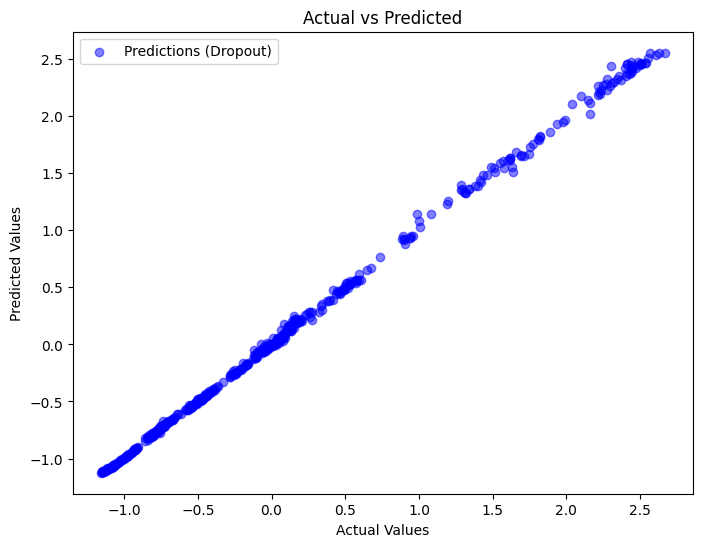

In [211]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, model.predict(x_test_reshaped), label='Predictions (Dropout)', alpha=0.5, color='blue')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
